## Imports

In [1]:
import torch
import torchvision
import numpy as np
import pandas as pd
from PIL import Image, ImageOps
import matplotlib.pyplot as plt
from pathlib import Path
from glob import  glob
import seaborn as sns
import albumentations as A
import albumentations.pytorch as Apy

from torchvision import datasets, transforms, models
import segmentation_models_pytorch as smp
import timm
import cv2 as cv2
import itertools
import math
import scipy

# clustering and dimension reduction
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from yellowbrick.cluster import KElbowVisualizer, SilhouetteVisualizer

/home/pedke/multi-task-learning/pedke-venv/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Utils

### Model 

In [2]:
# set up model name
model_name = 'resnet50'

# create model
# model = timm.create_model(model_name, pretrained=True, features_only=True) # unpooled, feature pyramid
model = timm.create_model(model_name, pretrained=True, num_classes=0) # pooled


In [3]:
model

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (act1): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (act1): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (drop_block): Identity()
      (act2): ReLU(inplace=True)
      (aa): Identity()
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
     

In [4]:
model2 = models.resnet50(pretrained=True)
newmodel = torch.nn.Sequential(*(list(model.children())[:-1]))
print(newmodel)

/home/pedke/multi-task-learning/pedke-venv/lib/python3.8/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  warnings.warn(
/home/pedke/multi-task-learning/pedke-venv/lib/python3.8/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Sequential(
  (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (2): ReLU(inplace=True)
  (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (4): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (act1): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (drop_block): Identity()
      (act2): ReLU(inplace=True)
      (aa): Identity()
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (act3): ReLU(in

### Data transforms

In [5]:
data_config = timm.data.resolve_model_data_config(model)
transforms = timm.data.create_transform(**data_config, is_training=False)

In [6]:
transforms

Compose(
    Resize(size=235, interpolation=bicubic, max_size=None, antialias=None)
    CenterCrop(size=(224, 224))
    ToTensor()
    Normalize(mean=tensor([0.4850, 0.4560, 0.4060]), std=tensor([0.2290, 0.2240, 0.2250]))
)

## Generating image features

In [7]:
image_dir = "/home/pedke/dataset/datasets/15-October-23_split - no_special_chars/train/images/"
image_dir_2 = "/home/pedke/dataset/datasets/15-October-23_split - no_special_chars/train-2/images/"
dirs = [image_dir, image_dir_2]

In [8]:
o = model(torch.randn(2, 3, 224, 224))
o.shape

torch.Size([2, 2048])

In [9]:
counter = 0
data = {}

for dir_ in dirs:
    for path in Path(dir_).glob("*"): 
        counter += 1
        print(counter)
        score_name = path.stem
        
        img = ImageOps.exif_transpose(Image.open(path)).convert("RGB")
        
        # print(path)
        # print(transforms(img).shape)
        
        output = model(transforms(img).unsqueeze(0))
        
        # # unpooled, feature pyramid
        # assert (output[-1].shape == torch.Size([1, 2048, 7, 7]))
        # data[score_name] = output[-1].flatten(start_dim=1).detach()
        
        
        assert (output.shape == torch.Size([1, 2048]))
        data[score_name] = output.detach()
        
        # for o in output:
        #     # print shape of each feature map in output
        #     # e.g.:
        #     #  torch.Size([1, 64, 112, 112])
        #     #  torch.Size([1, 256, 56, 56])
        #     #  torch.Size([1, 512, 28, 28])
        #     #  torch.Size([1, 1024, 14, 14])
        #     #  torch.Size([1, 2048, 7, 7])

        #     print(o.shape)
        

1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272


In [10]:
# get a list of the filenames
filenames = np.array(list(data.keys()))

In [11]:
# get a list of just the features
feat = list(data.values())
feat = np.array([i.numpy() for i in feat])
feat.shape

(272, 1, 2048)

In [12]:
(210, 1, 4096)

# reshape so that there are 210 samples of 4096 vectors
# feat = feat.reshape(-1,100352)

# feat = feat.reshape((155,-1,4096))
feat = feat.squeeze(1)
feat.shape


(272, 2048)

### PCA

In [25]:
pca = PCA(n_components=150, random_state=22)
pca.fit(feat)
x = pca.transform(feat)

# x=feat

In [26]:
pca.explained_variance_ratio_ ,np.sum(pca.explained_variance_ratio_)

(array([0.0625589 , 0.03282445, 0.01958609, 0.01448419, 0.0134462 ,
        0.01152312, 0.01073147, 0.00980161, 0.00959366, 0.00941606,
        0.00847192, 0.00829018, 0.00804508, 0.0078383 , 0.00765104,
        0.00740491, 0.00718066, 0.00701797, 0.00690805, 0.00676858,
        0.00666432, 0.00656065, 0.00648793, 0.00630146, 0.00624244,
        0.00616268, 0.00611864, 0.00606802, 0.00605877, 0.00591665,
        0.00585495, 0.00578979, 0.00572071, 0.00566046, 0.00554149,
        0.00547717, 0.00544028, 0.00538698, 0.00528514, 0.0052574 ,
        0.00520767, 0.00516832, 0.00513169, 0.00509773, 0.00502983,
        0.0049734 , 0.00491481, 0.00490449, 0.0048326 , 0.0048175 ,
        0.00477735, 0.00476783, 0.004751  , 0.00465329, 0.00456701,
        0.00455926, 0.00454116, 0.00449029, 0.00445359, 0.00443782,
        0.00441148, 0.00437141, 0.00436671, 0.00429549, 0.00428193,
        0.00425111, 0.00422644, 0.00417266, 0.00412823, 0.00412589,
        0.00408678, 0.00408106, 0.00404294, 0.00

In [27]:
print(f"Components before PCA: {feat.shape[1]}")
print(f"Components after PCA: {pca.n_components}")
print(f"Components after PCA: {x.shape[1]}")

Components before PCA: 2048
Components after PCA: 150
Components after PCA: 150


### KMEANS

In [28]:
kmeans = KMeans(n_clusters=4, random_state=22)
kmeans.fit(x)


/home/pedke/multi-task-learning/pedke-venv/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


KMeans(n_clusters=4, random_state=22)

In [29]:
kmeans.n_iter_

7

In [30]:
kmeans.labels_

array([1, 1, 2, 2, 2, 3, 2, 3, 3, 1, 0, 3, 1, 1, 3, 1, 3, 1, 2, 2, 1, 3,
       3, 2, 1, 1, 3, 1, 3, 1, 1, 2, 1, 2, 3, 1, 1, 1, 1, 1, 2, 1, 1, 2,
       1, 2, 1, 1, 1, 3, 1, 2, 1, 2, 2, 3, 3, 2, 1, 2, 1, 3, 3, 3, 2, 1,
       1, 2, 1, 1, 2, 3, 3, 0, 1, 0, 3, 3, 1, 1, 1, 1, 2, 2, 1, 0, 3, 1,
       1, 1, 3, 1, 1, 1, 1, 2, 3, 2, 1, 1, 3, 3, 3, 1, 1, 1, 2, 1, 2, 3,
       2, 1, 3, 2, 2, 1, 3, 2, 2, 1, 1, 1, 3, 1, 3, 3, 2, 1, 1, 2, 2, 3,
       2, 3, 2, 1, 2, 2, 1, 3, 2, 3, 2, 2, 2, 2, 3, 3, 1, 3, 1, 2, 1, 2,
       2, 1, 3, 2, 1, 2, 3, 1, 1, 1, 3, 1, 3, 3, 1, 3, 3, 3, 1, 1, 1, 3,
       1, 2, 0, 2, 2, 2, 1, 2, 2, 1, 1, 3, 2, 1, 1, 1, 1, 1, 2, 2, 2, 3,
       3, 3, 2, 2, 1, 3, 2, 2, 2, 3, 2, 1, 3, 2, 0, 3, 3, 3, 0, 2, 1, 2,
       3, 2, 2, 0, 1, 2, 3, 1, 1, 2, 2, 2, 3, 2, 1, 1, 1, 3, 1, 2, 2, 2,
       1, 2, 1, 1, 0, 1, 2, 0, 1, 1, 3, 3, 2, 2, 3, 2, 2, 1, 2, 2, 2, 1,
       1, 2, 2, 3, 0, 2, 3, 1], dtype=int32)

In [31]:
unique, counts = np.unique(kmeans.labels_, return_counts=True)
unique, counts

(array([0, 1, 2, 3], dtype=int32), array([ 11, 104,  89,  68]))

#### Elbow visualizer

/home/pedke/multi-task-learning/pedke-venv/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/home/pedke/multi-task-learning/pedke-venv/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/home/pedke/multi-task-learning/pedke-venv/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/home/pedke/multi-task-learning/pedke-venv/lib/python3.8/site-packages/sklearn/cluster/_kme

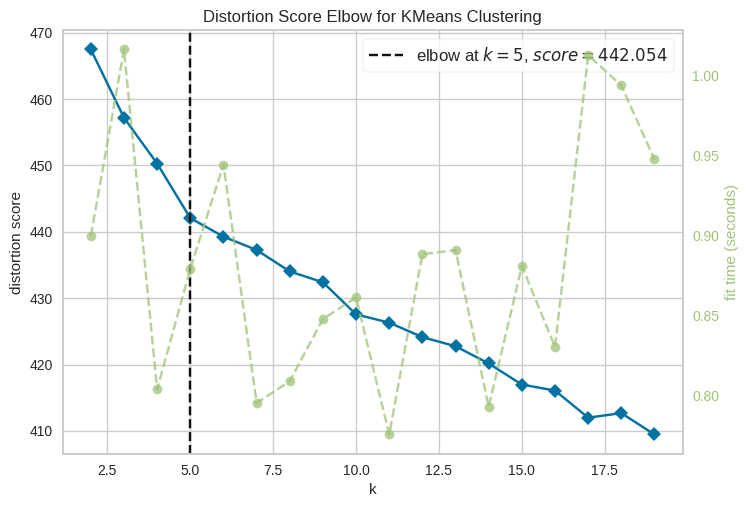

<Axes: title={'center': 'Distortion Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='distortion score'>

In [32]:
km = KMeans(random_state=42)
visualizer = KElbowVisualizer(km, k=(2,20))
visualizer.fit(x)        # Fit the data to the visualizer
visualizer.show()

#### Silhouette visualizer

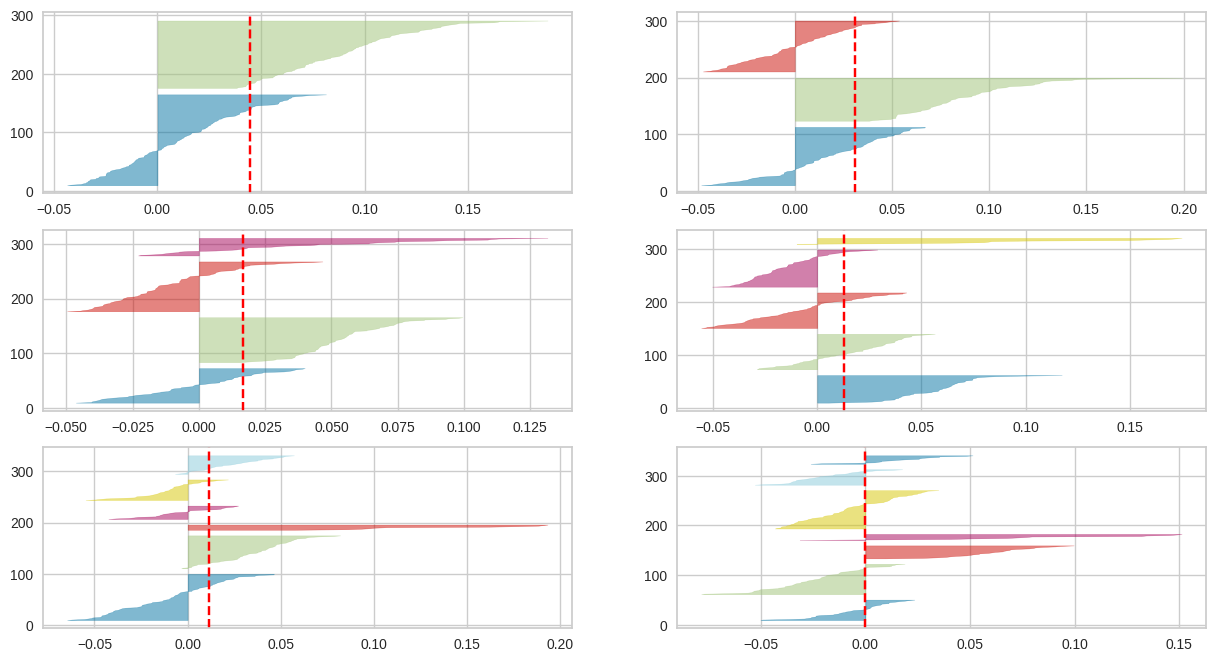

In [33]:
fig, ax = plt.subplots(3, 2, figsize=(15,8))
for i in [2, 3, 4, 5, 6, 7]:
    '''
    Create KMeans instances for different number of clusters
    '''
    km = KMeans(n_clusters=i, init='k-means++', n_init=10, max_iter=100, random_state=42)
    q, mod = divmod(i, 2)
    '''
    Create SilhouetteVisualizer instance with KMeans instance
    Fit the visualizer
    '''
    visualizer = SilhouetteVisualizer(km, colors='yellowbrick', ax=ax[q-1][mod])
    visualizer.fit(x) 

In [163]:
iterations = 10
centroids = None

for i in range(iterations):
    kmeans = KMeans(
        max_iter=1,
        n_init=1,
        init=(centroids if centroids is not None else 'k-means++'),
        n_clusters=4,
        random_state=1)
    kmeans.fit(x)
    centroids = kmeans.cluster_centers_
    print(f'iter: {i} - first: {centroids[0]}, second: {centroids[1]}, third: {centroids[2]}, fourth: {centroids[3]}')

iter: 0 - first: [ 2.69018441e-01  3.54114860e-01  2.85707321e-02  1.44160062e-01
  1.38896137e-01  3.38799506e-03  4.78596240e-03  3.94187458e-02
 -1.21658118e-02  2.05410793e-02  2.20732838e-02 -5.42606711e-02
 -2.24443804e-02  7.92619865e-03  1.20303882e-02 -1.97700150e-02
 -3.67597789e-02 -3.50536332e-02 -2.81620082e-02 -3.11051626e-02
 -9.38129786e-04  6.09048549e-03  1.19762821e-02  2.83416305e-02
 -3.92030813e-02 -1.14343511e-02 -3.09630055e-02  2.78122779e-02
  2.35747192e-02 -4.63398453e-03 -8.81800894e-03  1.39883440e-02
  1.55519764e-03  2.17945669e-02  2.41206419e-02 -2.16275696e-02
 -3.31002218e-03  6.49118610e-03  1.60133913e-02  3.93604580e-03
  7.13229878e-03 -2.88151130e-02 -3.61104356e-03  1.49635961e-02
  2.74164584e-02 -8.05861130e-03  2.03377306e-02 -1.56515483e-02
 -3.31121087e-02 -4.59277956e-03 -7.47471990e-04 -4.32418339e-04
 -9.75152419e-04 -2.68022101e-02  6.35731965e-03  9.18271206e-03
 -6.45587640e-03 -3.73212970e-03 -7.24938838e-03 -2.34392155e-02
 -3.5211